In [37]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
import cv2
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def create_dataframe(folder_path):
    images = []
    labels = []

    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if  class_name.startswith('Potato'):
          if os.path.isdir(class_path):
              # Iterate through each image file in the directory
              for image_name in os.listdir(class_path):
                  image_path = os.path.join(class_path, image_name)
                  if os.path.isfile(image_path):
                      # Append image path and label to lists
                      images.append(image_path)
                      labels.append(class_name)
        else:
          continue

    df = pd.DataFrame({'images': images, 'label': labels})
    return df

folder_path = '/content/drive/MyDrive/new_dataset/train'

df = create_dataframe(folder_path)

print(df.head())
print(df['label'].unique())

In [ ]:
def feature_extractor(dataset):
    feature_dataset = pd.DataFrame()

    for index, row in dataset.iterrows():
        img_url = row['images']
        label = row['label']



        img=cv2.imread(img_url)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


        GLCM = greycomatrix(img, [1], [0])
        GLCM_Energy = greycoprops(GLCM, 'energy')[0]
        GLCM_corr = greycoprops(GLCM, 'correlation')[0]
        GLCM_diss = greycoprops(GLCM, 'dissimilarity')[0]
        GLCM_hom = greycoprops(GLCM, 'homogeneity')[0]
        GLCM_contr = greycoprops(GLCM, 'contrast')[0]


        entropy = shannon_entropy(img)


        features_row = {
            'Energy': GLCM_Energy,
            'Corr': GLCM_corr,
            'Diss_sim': GLCM_diss,
            'Homogen': GLCM_hom,
            'Contrast': GLCM_contr,
            'Entropy': entropy,
            'Label': label
        }
        print(features_row)
        # Append the row to the feature dataset
        feature_dataset = pd.concat([feature_dataset, pd.DataFrame(features_row, index=[0])], ignore_index=True)

    return feature_dataset

In [ ]:
lak=feature_extractor(df)

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
lak['Label'] = label_encoder.fit_transform(lak['Label'])

In [ ]:
lak.to_csv('new_pds_dataset.csv')

In [2]:
df=pd.read_csv('new_pds_dataset.csv')

In [3]:
df

,Unnamed: 0,Energy,Corr,Diss_sim,Homogen,Contrast,Entropy,Label
0,0,0.306666,0.951567,10.713971,0.374275,344.117188,6.037841,4
1,1,0.502182,0.961904,7.143597,0.547554,204.740135,4.572808,4
2,2,0.672913,0.965631,5.985754,0.707274,228.273805,3.388024,4
3,3,0.170205,0.973170,7.705070,0.324191,175.205162,6.804935,4
4,4,0.498842,0.954470,10.907813,0.529992,442.306311,4.767776,4
...,...,...,...,...,...,...,...,...
7819,7819,0.530665,0.920156,11.264384,0.562591,538.234697,4.434188,0
7820,7820,0.497991,0.911705,12.029197,0.544578,597.114828,4.679198,0
7821,7821,0.528365,0.920394,11.293873,0.563229,550.661336,4.437868,0
7822,7822,0.378931,0.857751,15.530193,0.416305,760.588771,5.461024,0


In [14]:
X = df.drop(['Label','Unnamed: 0'],axis=1)
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Best Parameters: {'C': 100, 'kernel': 'rbf'}
Confusion Matrix:
[[  0  36  57   8   6  14   7   8   5   1]
 [  0 104   4  22   9   2   2   0   0   0]
 [  0   0 108  10   6  22   5   1   2   0]
 [  0  37  41  32  24   7  10   1   0   0]
 [  0  14  25  25  71  34   2   1   0   0]
 [  0   0  25   1   1 117   3   4   1   1]
 [  0  33  17  10  16  13  67   3   2   0]
 [  0   8   7   7   1  10  17  33  43  47]
 [  0   2   3   7   2   2   8  24  97  16]
 [  0   0   0   1   2   1   6   4  16 124]]
The accuracy: 0.6242811501597444


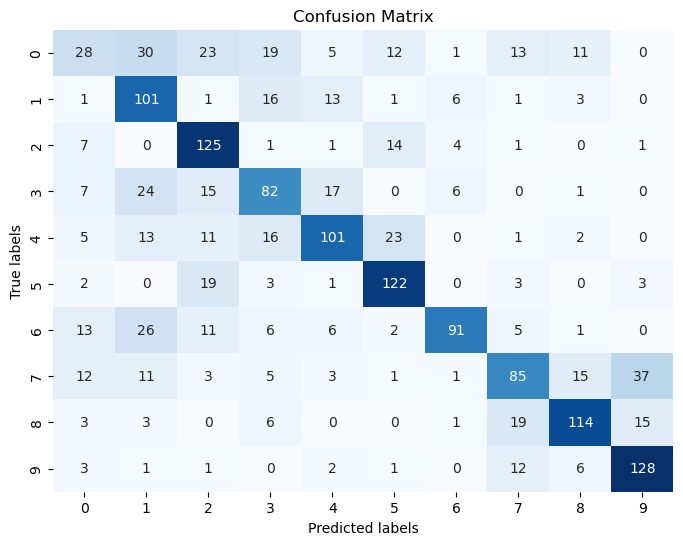

In [46]:
param_grid = {
    'C': [100],
    'kernel': ['rbf'],
}

svc = SVC()

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_scaled, y_train)


best_params = grid_search.best_params_
print("Best Parameters:", best_params)


best_svc = SVC(**best_params)


best_svc.fit(X_train_scaled, y_train)


y_pred = best_svc.predict(X_test_scaled)


cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


acc = accuracy_score(y_test, y_pred)
print("The accuracy:", acc)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


Confusion Matrix:
[[ 31  27  21  12   7  12   6  12  14   0]
 [  6  94   3  12  12   0  11   1   4   0]
 [  2   0 120   0   6  19   5   2   0   0]
 [  5  28  14  71  15   0  15   1   3   0]
 [  6  16  16  20  85  22   5   1   1   0]
 [  0   1  20   2   3 120   0   2   1   4]
 [ 12  25  19  19   7   4  68   5   2   0]
 [ 10  10   4   6   4   1   0  65  40  33]
 [  7   6   1   9   0   0   0  27 100  11]
 [  0   0   3   3   3   2   0  19   6 118]]
accuracy: 0.5571884984025559


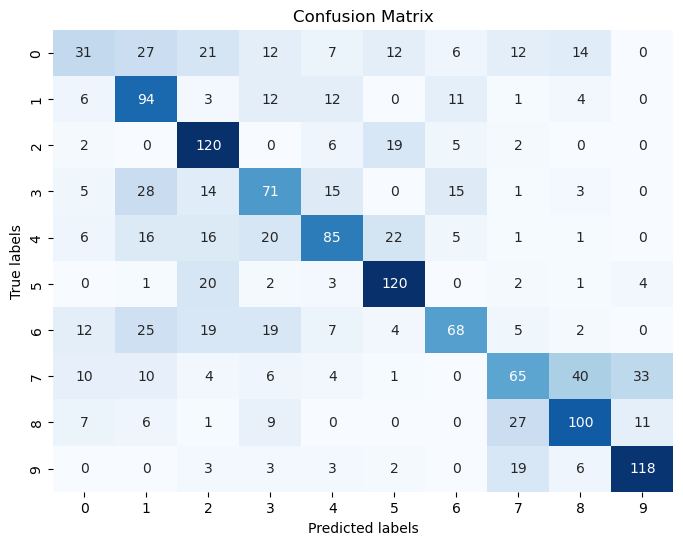

In [43]:
rf = RandomForestClassifier(n_estimators=200,max_depth=15,min_samples_leaf=2)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)


conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


acc = accuracy_score(y_test, y_pred)
print("accuracy:", acc)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [45]:
ann_model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.2), 
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),          
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dense(12) 
])

ann_model.compile(optimizer='adam', loss='mse')

checkpoint_path = "model_checkpoint_pds.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
ann_model.fit(X_train_scaled, y_train, epochs=40, batch_size=32, validation_split=0.2,callbacks=[checkpoint])

loade_model = load_model(checkpoint_path)
extracted_features_train = loade_model.predict(X_train_scaled)
extracted_features_test = loade_model.predict(X_test_scaled)

scaler = StandardScaler()
scaled_extracted_features_train = scaler.fit_transform(extracted_features_train)
scaled_extracted_features_test = scaler.transform(extracted_features_test)


svc_model = SVC(C=10, kernel='rbf')
svc_model.fit(scaled_extracted_features_train, y_train)

y_pred = svc_model.predict(scaled_extracted_features_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

acc = accuracy_score(y_test, y_pred)
print("the accuracy:", acc)

Epoch 1/40
152/157 [============================>.] - ETA: 0s - loss: 25.6054
Epoch 1: val_loss improved from inf to 25.12165, saving model to model_checkpoint_pds.h5
157/157 [==============================] - 6s 13ms/step - loss: 25.5571 - val_loss: 25.1216
Epoch 2/40
151/157 [===========================>..] - ETA: 0s - loss: 15.8467
Epoch 2: val_loss improved from 25.12165 to 10.90305, saving model to model_checkpoint_pds.h5
157/157 [==============================] - 2s 10ms/step - loss: 15.6584 - val_loss: 10.9030
Epoch 3/40
153/157 [============================>.] - ETA: 0s - loss: 6.8893
Epoch 3: val_loss improved from 10.90305 to 5.10113, saving model to model_checkpoint_pds.h5
157/157 [==============================] - 2s 11ms/step - loss: 6.8388 - val_loss: 5.1011
Epoch 4/40
153/157 [============================>.] - ETA: 0s - loss: 4.7279
Epoch 4: val_loss improved from 5.10113 to 4.06854, saving model to model_checkpoint_pds.h5
157/157 [==============================] - 1s 10

157/157 [==============================] - 2s 14ms/step - loss: 3.5886 - val_loss: 3.2057
Epoch 37/40
157/157 [==============================] - ETA: 0s - loss: 3.5248
Epoch 37: val_loss improved from 3.15829 to 3.09841, saving model to model_checkpoint_pds.h5
157/157 [==============================] - 2s 12ms/step - loss: 3.5248 - val_loss: 3.0984
Epoch 38/40
150/157 [===========================>..] - ETA: 0s - loss: 3.5215
Epoch 38: val_loss did not improve from 3.09841
157/157 [==============================] - 1s 9ms/step - loss: 3.4996 - val_loss: 3.1556
Epoch 39/40
154/157 [============================>.] - ETA: 0s - loss: 3.4680
Epoch 39: val_loss did not improve from 3.09841
157/157 [==============================] - 2s 11ms/step - loss: 3.4665 - val_loss: 3.1645
Epoch 40/40
152/157 [============================>.] - ETA: 0s - loss: 3.4596
Epoch 40: val_loss did not improve from 3.09841
49/49 [==============================] - 0s 4ms/step
Confusion Matrix:
[[  0  36  57   8   6

In [31]:
base_estimator = DecisionTreeClassifier(max_depth=10)
n_estimators = 100
learning_rate = 1.0 
adaboost_clf = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)

adaboost_clf.fit(X_train_scaled, y_train)

y_pred = adaboost_clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.5571884984025559
